In [4]:
!pip install git+https://github.com/githubharald/CTCDecoder.git jiwer

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Cloning https://github.com/githubharald/CTCDecoder.git to /tmp/pip-req-build-8l92lteg
  Running command git clone -q https://github.com/githubharald/CTCDecoder.git /tmp/pip-req-build-8l92lteg
  Resolved https://github.com/githubharald/CTCDecoder.git to commit 6b5c3dd34944e5399a7308e241319b7f9c47e7c3


In [5]:
# Melihat GPU yang tersedia dan penggunaannya.
!nvidia-smi

Mon Apr 17 06:09:48 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.156.00   Driver Version: 450.156.00   CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      On   | 00000000:07:00.0 Off |                    0 |
| N/A   28C    P0    52W / 400W |      0MiB / 40537MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  A100-SXM4-40GB      On   | 00000000:0F:00.0 Off |                    0 |
| N/A   

In [6]:
# Memilih GPU yang akan digunakan (contohnya: GPU #7)
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '4'

In [7]:
# ROMAN_NUMERALS = "\u2160 \u2161 \u2162 \u2163 \u2164 \u2165 \u2166 \u2167 \u2168 \u2169 \u216A \u216B \u216C \u216D \u216E \u216F \u2180 \u2181 \u2182 \u2183".split()
# PEGON_CHARS = ['-'] + [' '] + 'َ ِ ُ ً ٍ ٌ ْ ّ ٰ ࣤ \u06e4 \u0653 ١ ٢ ٣ ٤ ٥ ٦ ٧ ٨ ٩ ٠ ة ح چ ج ث ت ب ا أ إ آ ؤ ى س ز ر ࢮ ڎ ذ د خ ع ظ ڟ ط ض ص ش ڮ ك ق ڤ ف ڠ غ ي ه و ۑ ئ ن م ل ۔ : ؛ ، ﴾ ﴿ ( ) ! ؟َ « » ۞ ء'.split()
PEGON_CHARS = ['-'] + [' '] + 'َ ِ ُ ً ٍ ٌ ْ ّ َ ٰ ࣤ \u06e4 \u0653 ١ ٢ ٣ ٤ ٥ ٦ ٧ ٨ ٩ ٠ ة ح چ ج ث ت ب ا أ إ آ ؤ ى س ز ر ࢮ ڎ ذ د خ ع ظ ڟ ط ض ص ش ڮ ك ق ڤ ف ڠ غ ي ه و ۑ ئ ن م ل ۔ : ؛ ، ( ) ! ؟ « » ۞ ء'.split()
CHAR_MAP = {letter: idx for idx, letter in enumerate(PEGON_CHARS)}

In [8]:
for i in CHAR_MAP.keys():
    try:
        assert len(i) == 1
    except AssertionError:
        print(i)
        raise

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
# from torchvision.transforms import Compose, ToTensor, Normalize
from torchvision.transforms import transforms

# Define the OCR model architecture
class OCRModel(nn.Module):
    def __init__(self, num_classes, image_height, image_width, max_seq_len,
               conv_channels=[32, 64]):
        super(OCRModel, self).__init__()

        self.max_seq_len = max_seq_len
        self.image_height = image_height
        self.image_width = image_width
        self.conv_channels = conv_channels

        # CNN part, downsampling 2 times
        self.conv1 = nn.Conv2d(in_channels=1,
                               out_channels=conv_channels[0],
                               kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=(2, 1))

        self.conv2 = nn.Conv2d(in_channels=conv_channels[0],
                               out_channels=conv_channels[1],
                               kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=(2, 1))

        # first dense
        self.fc1 = nn.Linear(in_features=conv_channels[1] * (self.image_height//4),
                             out_features=conv_channels[1])
        self.dropout = nn.Dropout(0.25)

        # RNN part
        self.lstm1 = nn.LSTM(input_size=conv_channels[1], hidden_size=128,
                             bidirectional=True, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=256, hidden_size=256,
                             bidirectional=True, batch_first=True)

        self.fc2 = nn.Linear(in_features=2*256, out_features=num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)

        x = self.pool1(x)

        x = self.conv2(x)
        x = F.relu(x)

        x = self.pool2(x)
        
#         print(x.shape)
        x = x.reshape(-1,
                      x.size(-1), # should be the width
                      (self.image_height//4) * self.conv_channels[1])

        x = self.fc1(x)

        x = self.dropout(x)
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = self.fc2(x)
        x = x.log_softmax(2)
        return x

In [23]:
import json
from PIL import Image
import torch
from torch.utils.data import Dataset
import os
import glob
import re
import datetime
import shutil
import pickle
import random
import unicodedata

class OCRDataset(Dataset):
    def __init__(self, file_dir, char_map, force_rewrite=False, skip_duplicates=False,
                img_format = 'png', sample=1, target_dir='tmp', in_img_format='png'):
        self.img_format = img_format
        self.target_dir = target_dir
        self.files_and_labels = []
        self.max_seq_len = 0
        total_seq_len = 0
        
        total_img_h = 0
        total_img_w = 0
        
        if os.path.exists(self.target_dir):
            if not force_rewrite:
                raise FileExistsError(f'{target_dir} already exists and force rewrite not allowed')
            else:
                shutil.rmtree(self.target_dir)
        os.makedirs(self.target_dir)
        files = glob.glob(os.path.join(file_dir, f"**/*.{in_img_format}"), recursive=True)
        for fullpath in random.sample(files, int(len(files) * sample)):

            with open(re.sub(f'.{in_img_format}$', '.json', fullpath), 'r') as f:
                bbox_list = json.load(f)
            with Image.open(fullpath) as image:
                for idx, obj in enumerate(bbox_list):
                    label = obj['text']
                    seq_len = len(label)
                    left, top, right, bottom = obj['bbox']
                    if (right - left) * (bottom - top) == 0:
                        label = obj['text']
                        print(f"Skipping empty bbox ({left}, {top}, {right}, {bottom}) and label {label}")
                        continue

                    cropped_image = image.crop(obj['bbox'])
                    target_timestamp = datetime.datetime.now().timestamp()
                    target_filepath = os.path.join(self.target_dir, f'{target_timestamp}.{self.img_format}')
                    cropped_image.save(target_filepath)
            
                    self.files_and_labels.append((target_timestamp, label))
                
                    self.max_seq_len = max(seq_len, self.max_seq_len)
                    total_seq_len += seq_len
                    total_img_h += bottom - top
                    total_img_w += right - left
                    
        self.avg_seq_len = int(total_seq_len / len(self.files_and_labels))
        self.avg_img_w = int(total_img_w / len(self.files_and_labels))
        self.avg_img_h = int(total_img_h / len(self.files_and_labels))

        self.char_map = char_map
        
        # Define the transforms to apply to the image patches
        self.transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.Resize((self.avg_img_h, self.avg_img_w)),
            transforms.ToTensor(),
          ])
        self.save()
        
    def save(self):
        with open(os.path.join(self.target_dir, 'metadata.pkl'), 'wb') as f:
            pickle.dump(self, f)
        with open(os.path.join(self.target_dir, 'filemap.pkl'), 'wb') as f:
            pickle.dump(self.files_and_labels, f)

    @classmethod
    def load(cls, filename):
        self = object.__new__(cls)
        self.__class__ = cls
        with open(filename, 'rb') as f:
            obj = pickle.load(f)
            self.__dict__.update(vars(obj))
        return self
    
    def __len__(self):
        return len(self.files_and_labels)

    def to_class(self, char):
        try:
            return self.char_map[char]
        except KeyError:
            return self.char_map['-']

    def __getitem__(self, idx):
        image_timestamp, label = self.files_and_labels[idx]
        image_path = os.path.join(self.target_dir, f'{image_timestamp}.{self.img_format}')
        cropped_image = self.transform(Image.open(image_path))
        label = [self.to_class(c) for c in filter(lambda c:unicodedata.category(c)[0] != 'C', label)]
        return cropped_image, label

In [24]:
# dataset = OCRDataset('/workspace/Dataset/Synthesized', CHAR_MAP,
#                     force_rewrite=True, skip_duplicates=True)
dataset = OCRDataset.load('tmp/metadata.pkl')

In [25]:
dataset.char_map = CHAR_MAP

dataset.transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((dataset.avg_img_h, dataset.avg_img_w)),
    transforms.ToTensor(),
  ])

dataset.save()

In [26]:
assert dataset.char_map == CHAR_MAP

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import transforms

from functools import partial

from tqdm import tqdm
import matplotlib.pyplot as plt

class CTCTrainer:
    def __init__(self, image_dir, char_map, batch_size,
                 blank_idx=0, lr=0.001, added_padding=1,
                 conv_channels=[32, 64],
                 dataset=None):
        self.image_dir = image_dir
        self.char_map = char_map
        # Define the batch size and number of epochs
        self.batch_size = batch_size

        # Define the dataset and dataloader
        if dataset != None:
            self.dataset = dataset
        else:
            self.dataset = OCRDataset(image_dir, char_map)
        self.dataloader = DataLoader(self.dataset,
                                     batch_size=self.batch_size,
                                     shuffle=True,
                                     collate_fn=self.collate_fn)

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.total_padded_len = self.dataset.max_seq_len + added_padding
        if self.total_padded_len > self.dataset.avg_img_w//4:
            print(f'[WARN] Total sequence length ({self.total_padded_len}) exceeds predicted sequence length ({self.dataset.avg_img_w//4})')
        # Define the model, criterion, and optimizer
        self.model = OCRModel(num_classes=len(char_map),
                              image_height=self.dataset.avg_img_h,
                              image_width=self.dataset.avg_img_w,
                              max_seq_len=self.total_padded_len,
                              conv_channels=conv_channels)\
                              .to(self.device)
        self.criterion = nn.CTCLoss(blank=blank_idx)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)

    def collate_fn(self, batch):
        max_len = self.total_padded_len
        # Sort the batch by sequence length (in descending order)
        batch = sorted(batch, key=lambda x: x[0].shape[2], reverse=True)

        # Extract the image tensors and label lists from the sorted batch
        images = [item[0] for item in batch]
        labels = [item[1] for item in batch]
        label_lengths = torch.LongTensor([len(label) for label in labels])
        # Pad the label lists with the blank token
        labels = [label[:max_len] + [self.char_map['-']] * (max_len-len(label[:max_len])) for label in labels]

        # Stack the image tensors into a single tensor
        images = torch.stack(images, dim=0)

        # Convert the label lists into tensors
        labels = torch.LongTensor(labels)

        return images, labels, label_lengths

    def train(self, num_epochs):
        self.loss_history = []
        self.model.train()
        for epoch in range(num_epochs):
            running_loss = 0.0
            for i, (images, labels, target_lengths) in (pbar := tqdm(enumerate(self.dataloader),
                                                                   total=len(self.dataloader))):
                # Move the data to the device (GPU if available)
                images = images.to(self.device)
                labels = labels.to(self.device)
                # print(torch.tensor([x.shape[1] for x in images]))
                # Zero the parameter gradients
                self.optimizer.zero_grad()

                # Forward pass
#                 print(images.shape)
                output = self.model(images)
                input_lengths = torch.full((len(labels),), output.shape[1],
                                            dtype=torch.long)
                # print(input_lengths.shape == (self.batch_size,))
                # print(output.shape)
                # print(labels.shape)
                # print(target_lengths)
                if output.mean().isnan():
                    raise ValueError('Output is NaN')
                # Compute the loss
                try:
                    loss = self.criterion(output.transpose(0, 1), labels,
                                          input_lengths=input_lengths,
                                          target_lengths=target_lengths)
                except RuntimeError:
                    print(target_lengths.shape)
                    print(labels.shape)
                    print(input_lengths.shape)
                    print(output.shape)
                    raise

                # Backward pass and optimize
                loss.backward()
                self.optimizer.step()

                # Add the batch loss to the running loss
                running_loss += loss.item()

                # Print the average loss every batch
                pbar.set_description(f"Epoch [{epoch+1}/{num_epochs}] | Batch [{i+1}/{len(self.dataloader)}] | Running Loss: {running_loss/(((i+1)/len(self.dataloader))*len(self.dataset)):.4f}")
            self.loss_history.append(running_loss/len(self.dataset))

        print("Finished training!")
        return self.model

    def save(self, path):
        torch.save(self.model, path)

    def plot_history(self, path=None):
        plt.plot(self.loss_history)
        if path != None:
            plt.savefig(path)
        plt.show()


In [28]:
# Train the model
trainer = CTCTrainer('/workspace/Dataset/Synthesized',
                     CHAR_MAP,
                     batch_size=32, added_padding=25,
                     conv_channels=[64, 32], dataset=dataset)

In [29]:
assert trainer.char_map == CHAR_MAP
assert trainer.model(torch.randn(32, 1, trainer.model.image_height, trainer.model.image_width)\
                     .to(trainer.device)).shape[-1] == len(CHAR_MAP)

In [30]:
timestamp = datetime.datetime.now()
print(timestamp)

2023-04-17 06:11:47.831042


Epoch [1/10] | Batch [2453/2453] | Running Loss: 0.1130: 100%|██████████| 2453/2453 [15:28<00:00,  2.64it/s]
Epoch [2/10] | Batch [2453/2453] | Running Loss: 0.0950: 100%|██████████| 2453/2453 [17:13<00:00,  2.37it/s]
Epoch [3/10] | Batch [2453/2453] | Running Loss: 0.0883: 100%|██████████| 2453/2453 [16:51<00:00,  2.42it/s]
Epoch [4/10] | Batch [2453/2453] | Running Loss: 0.0874: 100%|██████████| 2453/2453 [16:14<00:00,  2.52it/s]
Epoch [5/10] | Batch [2453/2453] | Running Loss: 0.0893: 100%|██████████| 2453/2453 [16:06<00:00,  2.54it/s]
Epoch [6/10] | Batch [2453/2453] | Running Loss: 0.0861: 100%|██████████| 2453/2453 [15:59<00:00,  2.56it/s]
Epoch [7/10] | Batch [2453/2453] | Running Loss: 0.0850: 100%|██████████| 2453/2453 [16:13<00:00,  2.52it/s]
Epoch [8/10] | Batch [2453/2453] | Running Loss: 0.0852: 100%|██████████| 2453/2453 [13:51<00:00,  2.95it/s]
Epoch [9/10] | Batch [2453/2453] | Running Loss: 0.0856: 100%|██████████| 2453/2453 [13:16<00:00,  3.08it/s]
Epoch [10/10] | Bat

Finished training!


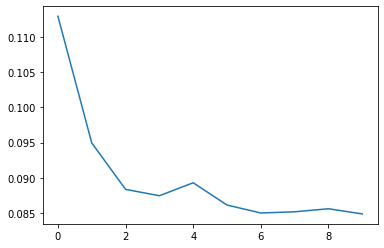

In [31]:
trainer.train(num_epochs=10)
trainer.plot_history(path=f'ctc-wide-crnn/{timestamp}.png')
trainer.save(f'ctc-wide-crnn/{timestamp}.pt')

In [32]:
class CTCDecoder:
    def __init__(self, model, char_map, blank_char='-'):
        self.model = model.eval()
        self.alphabet = list(char_map.keys())
        self.blank_char = blank_char
        blank_idxs = [idx for idx, x in enumerate(self.alphabet) if x == self.blank_char]
        assert len(blank_idxs) == 1
        self.blank_index = blank_idxs[0]
    
    @classmethod
    def from_path(cls, model_path, alphabet):
        saved_model = torch.load(model_path)
        return cls(saved_model, alphabet)
    
    def convert_to_text(self, output):
        output = torch.argmax(output, dim=2).detach().cpu().numpy()
        texts = []
        for i in range(output.shape[0]):
            text = ''
            for j in range(output.shape[1]):
                if output[i, j] != self.blank_index and (j == 0 or output[i, j] != output[i, j-1]):
                    text += self.alphabet[output[i, j]]
            texts.append(text)
        return texts
    
    def infer(self, data):
        model_out = self.model(data)
#         print(model_out.shape)
        return self.convert_to_text(model_out)

In [33]:
from ctc_decoder import best_path, beam_search
from ctcdecode import CTCBeamDecoder
import pdb

class BestPathDecoder(CTCDecoder):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.all_chars = [x for x in self.alphabet if x != self.blank_char]
        
    def convert_to_text(self, output):
        output = torch.roll(F.softmax(output, dim=2), -1, 2).detach().cpu().numpy()
        texts = []
        for i in range(output.shape[0]):
#             pdb.set_trace()
            texts.append(best_path(output[i, :, :], self.all_chars))
        return texts

class BeamSearchDecoder(CTCDecoder):
    def __init__(self, *args, beam_width=100, **kwargs):
        super().__init__(*args, **kwargs)
        self.all_chars = [x for x in self.alphabet if x != self.blank_char]
        self.beam_width=beam_width
#         self.decoder = CTCBeamDecoder(
#             self.alphabet,
#             model_path=None,
#             alpha=0,
#             beta=0,
#             cutoff_top_n=40,
#             cutoff_prob=1.0,
#             beam_width=beam_width,
#             num_processes=4,
#             blank_id=self.blank_index,
#             log_probs_input=False)
    
    @classmethod
    def from_path(cls, *args, beam_width=100, **kwargs):
        self = super().from_path(*args, **kwargs)
        self.all_chars = [x for x in self.alphabet if x != self.blank_char]
        self.beam_width = beam_width
        return self
        
    def convert_to_text(self, output):
        output = torch.roll(F.softmax(output, dim=2), -1, 2).detach()
        texts = []
        for i in range(output.shape[0]):
            texts.append(beam_search(output[i, :, :], self.all_chars,
                                     beam_width=self.beam_width))
#         res, _, _, out_lens = self.decoder.decode(output)
#         texts = [''.join([tensor[0][:out_len]]) for tensor, out_len in zip(res, out_lens)]
        return texts

In [34]:
from jiwer import wer, cer
from itertools import starmap

def evaluate(decoder, dataloader, char_map):
    char_map = {v: k for k,v in char_map.items()}
    
    def decode(arr, target_length):
        return ''.join(list(map(lambda x:char_map[x], arr[:target_length])))
    
    cers = []
    wers = []
    tot_cer = 0
    tot_wer = 0
    num_examples = 0
    for i, (images, labels, target_lengths) in (pbar := tqdm(enumerate(dataloader),
                                                             total=len(dataloader))):
            images = images.to('cuda')
            labels = labels.numpy()
            outputs = decoder.infer(images)
            for j, (output, true_label) in enumerate(zip(outputs, starmap(decode, zip(labels, target_lengths)))):
                label = true_label.replace('-', '')
                try:
                    cer_ = cer(label, output)
                    wer_ = wer(label, output)
                except ValueError:
                    pbar.write(f'[WARN]: ValueError with predicted {output} and label {label}')
                    if label == '':
                        continue
                    cer_ = 1
                    wer_ = 1
                cers.append(cer_)
                wers.append(wer_)
                tot_cer += cer_
                tot_wer += wer_
                num_examples += 1
                pbar.set_description(f" Example: {num_examples} | CER: {tot_cer/(num_examples):.4f} | WER: {tot_wer/(num_examples):.4f}")
    return cers, wers

In [35]:
import numpy as np
import matplotlib.pyplot as plt

def plot_cer_wer(cers, wers):
    cer_mean = np.mean(cers)
    wer_mean = np.mean(wers)
    fig, axs = plt.subplots(1, 2, figsize=(20, 4))
    axs[0].hist(cers, bins=100)
    axs[0].axvline(x=cer_mean, color='orange')
    axs[0].text(cer_mean,5.0, f'mean={cer_mean:.2f}')
    axs[0].set_title(f'CER')
    axs[1].hist(wers, bins=100)
    axs[1].set_title('WER')
    axs[1].text(wer_mean,5.0, f'mean={wer_mean:.2f}')
    axs[1].axvline(x=wer_mean, color='orange')
    plt.show()

In [36]:
dataloader = trainer.dataloader

In [37]:
model_path = f'ctc-wide-crnn/{timestamp}.pt'

In [38]:
decoder = BestPathDecoder.from_path(model_path, CHAR_MAP)
cers, wers = evaluate(decoder, dataloader, CHAR_MAP)

 Example: 191 | CER: 0.8877 | WER: 1.0569:   0%|          | 6/2453 [00:01<10:37,  3.84it/s]

[WARN]: ValueError with predicted  and label 


 Example: 894 | CER: 0.8871 | WER: 1.0798:   1%|          | 28/2453 [00:07<10:38,  3.80it/s]

[WARN]: ValueError with predicted  and label 


 Example: 1213 | CER: 0.8873 | WER: 1.0759:   2%|▏         | 38/2453 [00:10<10:09,  3.96it/s]

[WARN]: ValueError with predicted  and label 


 Example: 2493 | CER: 0.8870 | WER: 1.0766:   3%|▎         | 78/2453 [00:20<10:07,  3.91it/s]

[WARN]: ValueError with predicted أٰ أٰ  أٰ أ: and label   


 Example: 2908 | CER: 0.8869 | WER: 1.0763:   4%|▎         | 91/2453 [00:23<10:15,  3.84it/s]

[WARN]: ValueError with predicted  and label 


 Example: 3260 | CER: 0.8872 | WER: 1.0757:   4%|▍         | 102/2453 [00:26<10:16,  3.81it/s]

[WARN]: ValueError with predicted أٰم أٰ أ أ أٰ أٰٰلٰ and label   


 Example: 3931 | CER: 0.8872 | WER: 1.0766:   5%|▌         | 123/2453 [00:31<08:38,  4.49it/s]

[WARN]: ValueError with predicted  and label 


 Example: 5466 | CER: 0.8862 | WER: 1.0752:   7%|▋         | 171/2453 [00:44<09:44,  3.91it/s]

[WARN]: ValueError with predicted  and label 


 Example: 7129 | CER: 0.8863 | WER: 1.0753:   9%|▉         | 223/2453 [00:56<08:19,  4.46it/s]

[WARN]: ValueError with predicted : and label 


 Example: 7161 | CER: 0.8863 | WER: 1.0754:   9%|▉         | 224/2453 [00:56<08:43,  4.26it/s]

[WARN]: ValueError with predicted ۑٰ أٰ أٰٰل: and label   


 Example: 7832 | CER: 0.8863 | WER: 1.0762:  10%|▉         | 245/2453 [01:02<09:23,  3.92it/s]

[WARN]: ValueError with predicted  and label 


 Example: 8087 | CER: 0.8861 | WER: 1.0754:  10%|█         | 253/2453 [01:04<09:23,  3.90it/s]

[WARN]: ValueError with predicted : and label 


 Example: 8695 | CER: 0.8859 | WER: 1.0753:  11%|█         | 272/2453 [01:09<09:31,  3.82it/s]

[WARN]: ValueError with predicted ۑٰٰمٰ أٰٰمٰ أٰ أٰ إٰ أٰٰمٰ أٰٰ أٰٰ أٰ أٰمٰ and label      


 Example: 10615 | CER: 0.8857 | WER: 1.0775:  14%|█▎        | 332/2453 [01:24<09:14,  3.83it/s]

[WARN]: ValueError with predicted أٰمٰ أٰ أٰ  أٰ أٰ أٰ أٰ أٰ and label    


 Example: 11062 | CER: 0.8857 | WER: 1.0775:  14%|█▍        | 346/2453 [01:28<09:09,  3.84it/s]

[WARN]: ValueError with predicted  and label 


 Example: 11989 | CER: 0.8858 | WER: 1.0785:  15%|█▌        | 375/2453 [01:36<09:01,  3.84it/s]

[WARN]: ValueError with predicted  and label 


 Example: 12020 | CER: 0.8858 | WER: 1.0784:  15%|█▌        | 376/2453 [01:36<08:55,  3.88it/s]

[WARN]: ValueError with predicted  and label 


 Example: 14100 | CER: 0.8858 | WER: 1.0791:  18%|█▊        | 441/2453 [01:52<08:33,  3.92it/s]

[WARN]: ValueError with predicted ۑٰمٰ أٰم أٰ أٰ أٰ أٰ أٰ أٰ أٰ  and label    


 Example: 14964 | CER: 0.8858 | WER: 1.0791:  19%|█▉        | 468/2453 [01:59<08:13,  4.02it/s]

[WARN]: ValueError with predicted أٰ أٰ أٰل: and label   


 Example: 17204 | CER: 0.8860 | WER: 1.0785:  22%|██▏       | 538/2453 [02:17<08:12,  3.89it/s]

[WARN]: ValueError with predicted أٰ أٰ  أٰ and label   


 Example: 17524 | CER: 0.8860 | WER: 1.0786:  22%|██▏       | 548/2453 [02:19<08:08,  3.90it/s]

[WARN]: ValueError with predicted أٰ أٰ أٰ أٰ  أٰلٰ: and label   


 Example: 18708 | CER: 0.8860 | WER: 1.0783:  24%|██▍       | 585/2453 [02:29<08:23,  3.71it/s]

[WARN]: ValueError with predicted أٰمٰ أٰمٰ أٰ ظٰ أٰٰمٰ أٰٰٰ أٰٰ أٰٰ أٰ أٰٰ and label     


 Example: 20563 | CER: 0.8861 | WER: 1.0798:  26%|██▌       | 643/2453 [02:44<07:45,  3.89it/s]

[WARN]: ValueError with predicted  and label 


 Example: 21139 | CER: 0.8861 | WER: 1.0793:  27%|██▋       | 661/2453 [02:48<07:42,  3.88it/s]

[WARN]: ValueError with predicted ۑٰمٰ أٰم أٰ أٰم أٰ أٰ أٰ أٰ أٰ and label    


 Example: 21490 | CER: 0.8861 | WER: 1.0792:  27%|██▋       | 672/2453 [02:51<07:38,  3.89it/s]

[WARN]: ValueError with predicted  and label 


 Example: 22737 | CER: 0.8860 | WER: 1.0792:  29%|██▉       | 711/2453 [03:00<07:23,  3.93it/s]

[WARN]: ValueError with predicted  and label 


 Example: 23248 | CER: 0.8860 | WER: 1.0792:  30%|██▉       | 727/2453 [03:04<06:48,  4.23it/s]

[WARN]: ValueError with predicted  and label 


 Example: 23365 | CER: 0.8860 | WER: 1.0791:  30%|██▉       | 730/2453 [03:05<06:26,  4.45it/s]

[WARN]: ValueError with predicted  and label 


 Example: 23918 | CER: 0.8860 | WER: 1.0793:  30%|███       | 748/2453 [03:10<08:12,  3.46it/s]

[WARN]: ValueError with predicted  and label 


 Example: 25038 | CER: 0.8859 | WER: 1.0791:  32%|███▏      | 783/2453 [03:19<07:12,  3.86it/s]

[WARN]: ValueError with predicted أٰ أٰ  أٰ أٰ: and label   


 Example: 25101 | CER: 0.8859 | WER: 1.0790:  32%|███▏      | 785/2453 [03:19<06:32,  4.25it/s]

[WARN]: ValueError with predicted  and label 


 Example: 25229 | CER: 0.8859 | WER: 1.0789:  32%|███▏      | 789/2453 [03:20<06:16,  4.41it/s]

[WARN]: ValueError with predicted ۑٰمٰ أٰ أٰ أٰ أٰ أٰٰلٰ and label   


 Example: 25329 | CER: 0.8859 | WER: 1.0789:  32%|███▏      | 792/2453 [03:21<06:17,  4.40it/s]

[WARN]: ValueError with predicted أٰ أ أٰٰلٰ: and label   


 Example: 26509 | CER: 0.8859 | WER: 1.0786:  34%|███▍      | 829/2453 [03:29<06:06,  4.43it/s]

[WARN]: ValueError with predicted أٰم أٰ أٰ أٰ أٰ أٰ and label   


 Example: 27148 | CER: 0.8859 | WER: 1.0784:  35%|███▍      | 849/2453 [03:34<06:45,  3.96it/s]

[WARN]: ValueError with predicted  and label 


 Example: 28171 | CER: 0.8859 | WER: 1.0783:  36%|███▌      | 881/2453 [03:42<06:59,  3.75it/s]

[WARN]: ValueError with predicted  and label 


 Example: 28491 | CER: 0.8859 | WER: 1.0782:  36%|███▋      | 891/2453 [03:45<06:45,  3.85it/s]

[WARN]: ValueError with predicted أٰ أٰ أٰ أٰ أٰ أٰٰلٰ and label   


 Example: 28874 | CER: 0.8859 | WER: 1.0784:  37%|███▋      | 903/2453 [03:48<06:02,  4.28it/s]

[WARN]: ValueError with predicted  and label 


 Example: 30346 | CER: 0.8859 | WER: 1.0787:  39%|███▊      | 949/2453 [03:59<06:26,  3.89it/s]

[WARN]: ValueError with predicted ۑٰ أٰ أٰٰلٰ: and label   


 Example: 30473 | CER: 0.8859 | WER: 1.0787:  39%|███▉      | 953/2453 [04:00<06:22,  3.92it/s]

[WARN]: ValueError with predicted  and label 


 Example: 30952 | CER: 0.8860 | WER: 1.0787:  39%|███▉      | 968/2453 [04:04<06:08,  4.03it/s]

[WARN]: ValueError with predicted  and label 


 Example: 34280 | CER: 0.8861 | WER: 1.0793:  44%|████▎     | 1072/2453 [04:31<06:02,  3.81it/s]

[WARN]: ValueError with predicted أٰ أٰ أٰٰلٰ: and label   


 Example: 34439 | CER: 0.8861 | WER: 1.0792:  44%|████▍     | 1077/2453 [04:32<05:01,  4.57it/s]

[WARN]: ValueError with predicted  and label 


 Example: 34886 | CER: 0.8861 | WER: 1.0799:  44%|████▍     | 1091/2453 [04:35<05:12,  4.35it/s]

[WARN]: ValueError with predicted  and label 


 Example: 35280 | CER: 0.8861 | WER: 1.0798:  45%|████▍     | 1103/2453 [04:38<05:12,  4.32it/s]

[WARN]: ValueError with predicted  and label 


 Example: 35614 | CER: 0.8861 | WER: 1.0797:  45%|████▌     | 1113/2453 [04:40<04:47,  4.66it/s]

[WARN]: ValueError with predicted : and label  


 Example: 36079 | CER: 0.8861 | WER: 1.0794:  46%|████▌     | 1128/2453 [04:43<04:47,  4.61it/s]

[WARN]: ValueError with predicted أٰمٰ أٰ أٰ  أٰٰ أٰ أٰ أٰ أٰ and label    


 Example: 37444 | CER: 0.8863 | WER: 1.0792:  48%|████▊     | 1171/2453 [04:54<05:36,  3.81it/s]

[WARN]: ValueError with predicted : and label 


 Example: 38500 | CER: 0.8862 | WER: 1.0793:  49%|████▉     | 1204/2453 [05:02<05:28,  3.80it/s]

[WARN]: ValueError with predicted ۑٰمٰ أٰ أٰأٰ أٰٰٰ أٰمٰ أٰٰ أٰٰ أٰ أٰمٰ and label      


 Example: 39204 | CER: 0.8862 | WER: 1.0793:  50%|████▉     | 1226/2453 [05:08<04:40,  4.38it/s]

[WARN]: ValueError with predicted  and label 


 Example: 40451 | CER: 0.8862 | WER: 1.0790:  52%|█████▏    | 1265/2453 [05:17<05:11,  3.81it/s]

[WARN]: ValueError with predicted أٰ أ أٰٰلٰ: and label   


 Example: 43746 | CER: 0.8862 | WER: 1.0789:  56%|█████▌    | 1368/2453 [05:42<04:25,  4.08it/s]

[WARN]: ValueError with predicted أٰ أٰ  أٰ أ and label   
[WARN]: ValueError with predicted  and label 


 Example: 44449 | CER: 0.8862 | WER: 1.0789:  57%|█████▋    | 1390/2453 [05:47<04:32,  3.90it/s]

[WARN]: ValueError with predicted  and label 


 Example: 45024 | CER: 0.8862 | WER: 1.0790:  57%|█████▋    | 1408/2453 [05:51<03:44,  4.66it/s]

[WARN]: ValueError with predicted  and label 


 Example: 45695 | CER: 0.8862 | WER: 1.0790:  58%|█████▊    | 1429/2453 [05:57<04:26,  3.84it/s]

[WARN]: ValueError with predicted  and label 


 Example: 46174 | CER: 0.8862 | WER: 1.0788:  59%|█████▉    | 1444/2453 [06:01<04:19,  3.89it/s]

[WARN]: ValueError with predicted  and label 


 Example: 46685 | CER: 0.8862 | WER: 1.0788:  60%|█████▉    | 1460/2453 [06:05<04:12,  3.93it/s]

[WARN]: ValueError with predicted : and label 


 Example: 48924 | CER: 0.8862 | WER: 1.0790:  62%|██████▏   | 1530/2453 [06:23<03:52,  3.97it/s]

[WARN]: ValueError with predicted : and label 


 Example: 49756 | CER: 0.8862 | WER: 1.0788:  63%|██████▎   | 1556/2453 [06:29<03:49,  3.91it/s]

[WARN]: ValueError with predicted أٰأ أٰ أٰٰلٰ: and label   


 Example: 50587 | CER: 0.8862 | WER: 1.0785:  64%|██████▍   | 1582/2453 [06:36<03:43,  3.90it/s]

[WARN]: ValueError with predicted  and label 


 Example: 52058 | CER: 0.8862 | WER: 1.0784:  66%|██████▋   | 1628/2453 [06:48<03:27,  3.99it/s]

[WARN]: ValueError with predicted  and label 


 Example: 52826 | CER: 0.8862 | WER: 1.0784:  67%|██████▋   | 1652/2453 [06:54<03:27,  3.87it/s]

[WARN]: ValueError with predicted أٰ أ أ أٰ أٰ أٰٰلٰ: and label   


 Example: 53210 | CER: 0.8862 | WER: 1.0785:  68%|██████▊   | 1664/2453 [06:57<03:20,  3.93it/s]

[WARN]: ValueError with predicted أٰ أٰ  أ أٰ and label   


 Example: 58746 | CER: 0.8862 | WER: 1.0786:  75%|███████▍  | 1837/2453 [07:41<02:38,  3.89it/s]

[WARN]: ValueError with predicted ۑٰ أٰ أٰ أٰ أٰ: and label   


 Example: 64250 | CER: 0.8863 | WER: 1.0782:  82%|████████▏ | 2009/2453 [08:24<01:34,  4.68it/s]

[WARN]: ValueError with predicted أٰ أ أٰٰلٰ: and label   


 Example: 64442 | CER: 0.8863 | WER: 1.0783:  82%|████████▏ | 2015/2453 [08:25<01:30,  4.82it/s]

[WARN]: ValueError with predicted ۑٰ أ أٰ أٰ  أٰلٰ: and label   


 Example: 64890 | CER: 0.8863 | WER: 1.0783:  83%|████████▎ | 2029/2453 [08:28<01:46,  3.99it/s]

[WARN]: ValueError with predicted ۑٰٰمٰ أٰ أٰٰ أٰ ظٰمٰ أٰٰمٰ أٰٰ أٰٰ أٰ أٰمٰ and label      


 Example: 67706 | CER: 0.8863 | WER: 1.0785:  86%|████████▋ | 2117/2453 [08:51<01:26,  3.90it/s]

[WARN]: ValueError with predicted أٰمٰ أٰ أ أٰٰ أٰ أٰ أٰ أٰ and label   


 Example: 67738 | CER: 0.8863 | WER: 1.0784:  86%|████████▋ | 2118/2453 [08:52<01:26,  3.86it/s]

[WARN]: ValueError with predicted أٰ أٰ  أٰ أ: and label   


 Example: 68281 | CER: 0.8863 | WER: 1.0785:  87%|████████▋ | 2135/2453 [08:56<01:23,  3.83it/s]

[WARN]: ValueError with predicted  and label 


 Example: 68920 | CER: 0.8863 | WER: 1.0786:  88%|████████▊ | 2155/2453 [09:01<01:10,  4.23it/s]

[WARN]: ValueError with predicted  and label 


 Example: 69784 | CER: 0.8863 | WER: 1.0785:  89%|████████▉ | 2182/2453 [09:07<00:59,  4.58it/s]

[WARN]: ValueError with predicted ۑٰٰمٰ أٰٰمٰ أٰ أٰٰمٰ أٰٰمٰ أٰٰ أٰٰ أٰٰ أٰمٰ and label    


 Example: 70487 | CER: 0.8863 | WER: 1.0785:  90%|████████▉ | 2204/2453 [09:13<01:04,  3.85it/s]

[WARN]: ValueError with predicted  and label 


 Example: 70679 | CER: 0.8863 | WER: 1.0785:  90%|█████████ | 2210/2453 [09:14<01:01,  3.96it/s]

[WARN]: ValueError with predicted أٰ أٰ أٰٰلٰ: and label   


 Example: 70775 | CER: 0.8863 | WER: 1.0786:  90%|█████████ | 2213/2453 [09:15<01:03,  3.81it/s]

[WARN]: ValueError with predicted أٰ أٰ أٰ  ٰلٰ: and label   


 Example: 71895 | CER: 0.8863 | WER: 1.0785:  92%|█████████▏| 2248/2453 [09:24<00:49,  4.13it/s]

[WARN]: ValueError with predicted أٰ أٰ  أٰ أٰ: and label   


 Example: 72694 | CER: 0.8863 | WER: 1.0784:  93%|█████████▎| 2273/2453 [09:29<00:43,  4.15it/s]

[WARN]: ValueError with predicted  and label 


 Example: 73141 | CER: 0.8863 | WER: 1.0785:  93%|█████████▎| 2287/2453 [09:33<00:41,  3.96it/s]

[WARN]: ValueError with predicted  and label 


 Example: 74485 | CER: 0.8863 | WER: 1.0786:  95%|█████████▍| 2329/2453 [09:44<00:31,  3.89it/s]

[WARN]: ValueError with predicted أٰمٰ أٰ أٰ  أٰٰ أٰ أٰ أٰ أٰ and label    


 Example: 74708 | CER: 0.8863 | WER: 1.0786:  95%|█████████▌| 2336/2453 [09:47<00:34,  3.35it/s]

[WARN]: ValueError with predicted  and label 


 Example: 76595 | CER: 0.8863 | WER: 1.0786:  98%|█████████▊| 2395/2453 [10:01<00:14,  4.09it/s]

[WARN]: ValueError with predicted  and label 


 Example: 77074 | CER: 0.8863 | WER: 1.0786:  98%|█████████▊| 2410/2453 [10:05<00:11,  3.90it/s]

[WARN]: ValueError with predicted  and label 


 Example: 78193 | CER: 0.8863 | WER: 1.0784: 100%|█████████▉| 2445/2453 [10:14<00:02,  3.87it/s]

[WARN]: ValueError with predicted  and label 


 Example: 78420 | CER: 0.8863 | WER: 1.0784: 100%|██████████| 2453/2453 [10:16<00:00,  3.98it/s]


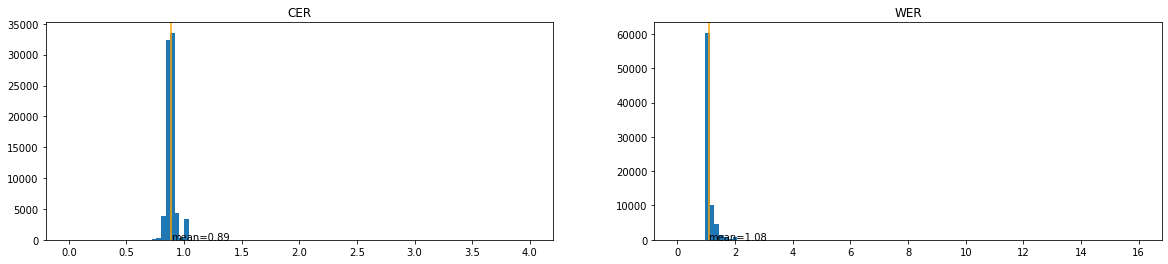

In [39]:
plot_cer_wer(cers, wers)

In [ ]:
# decoder1 = CTCDecoder.from_path(model_path, CHAR_MAP)
# decoder2 = BestPathDecoder.from_path(model_path, CHAR_MAP)
# decoder3 = BeamSearchDecoder.from_path(model_path, CHAR_MAP, beam_width=100)

In [ ]:
# cers, wers = evaluate(decoder1, dataloader, CHAR_MAP)

In [ ]:
# plot_cer_wer(cers, wers)
# del cers, wers

In [ ]:
# cers, wers = evaluate(decoder2, dataloader, CHAR_MAP)

In [ ]:
# plot_cer_wer(cers, wers)
# del cers, wers

In [ ]:
# cers, wers = evaluate(decoder3, dataloader, CHAR_MAP)

In [ ]:
# plot_cer_wer(cers, wers)
# del cers, wers